In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import pandas as pd
from data import stock_data
import sqlite3
import numpy as np
import matplotlib.pyplot as plt
from arch import arch_model
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf
from scipy.stats.mstats import winsorize
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch
from scipy.stats import jarque_bera

In [4]:
con = sqlite3.connect("stock_data.db", check_same_thread=False)

In [5]:
finance = ['JPM', 'BAC','GS']
tech = ['NVDA','AAPL','AMD']
crypto = ['MSTR','RIOT','COIN']
etf = ['SPY','QQQ','VTI']
all_stocks = finance + tech + crypto + etf

In [8]:
for stock in all_stocks:
    dt=stock_data(stock)
    dt.get_daily('full')
    dt.insert_table(con,if_exists='replace')

Data for JPM inserted into database
Data for BAC inserted into database
Data for GS inserted into database
Data for NVDA inserted into database
Data for AAPL inserted into database
Data for AMD inserted into database
{'Error Message': 'Invalid API call. Please retry or visit the documentation (https://www.alphavantage.co/documentation/) for TIME_SERIES_DAILY.'}
'stock_data' object has no attribute 'records'
{'Error Message': 'Invalid API call. Please retry or visit the documentation (https://www.alphavantage.co/documentation/) for TIME_SERIES_DAILY.'}
'stock_data' object has no attribute 'records'
Data for COIN inserted into database
Data for SPY inserted into database
Data for QQQ inserted into database
Data for VTI inserted into database


In [10]:
for stock in ['MSTR','RIOT']:
    dt=stock_data(stock)
    dt.get_daily('full')
    dt.insert_table(con,if_exists='replace')

Data for MSTR inserted into database
Data for RIOT inserted into database


In [6]:
def get_stock_data(stock_list):
    df_dict = {}
    for stock in stock_list:
        df = pd.read_sql(f"SELECT * FROM {stock}", con, parse_dates=['date'], index_col='date')
        df.index = pd.to_datetime(df.index, format='ISO8601')
        df.sort_index(inplace=True)
        df_dict[stock] = df
        df_dict[stock]['returns'] = np.log(df['close'] / df['close'].shift(1))*100 
        df_dict[stock].dropna(inplace=True)
    return df_dict

In [7]:
def plot_stock_data(df,feature='close',lags=20):
    fig, ax = plt.subplots(3, 2, figsize=(12, 10))
    for i, stock in enumerate(df):
        df[stock][feature].plot(ax=ax[i%3, 0], title=stock)
        plot_acf(df[stock]['returns']**2, lags=lags, ax=ax[i%3,1], title=f'{stock}')
        ax[i%3, 0].set_xlabel('Date')
        ax[i%3, 0].set_ylabel(feature.capitalize())
        ax[i%3, 0].grid(False)
        ax[i%3, 1].set_xlabel('Lags[Days]')
        ax[i%3, 1].set_ylabel('ACF')
        ax[i%3, 1].grid(False)
    plt.tight_layout()
    plt.show()

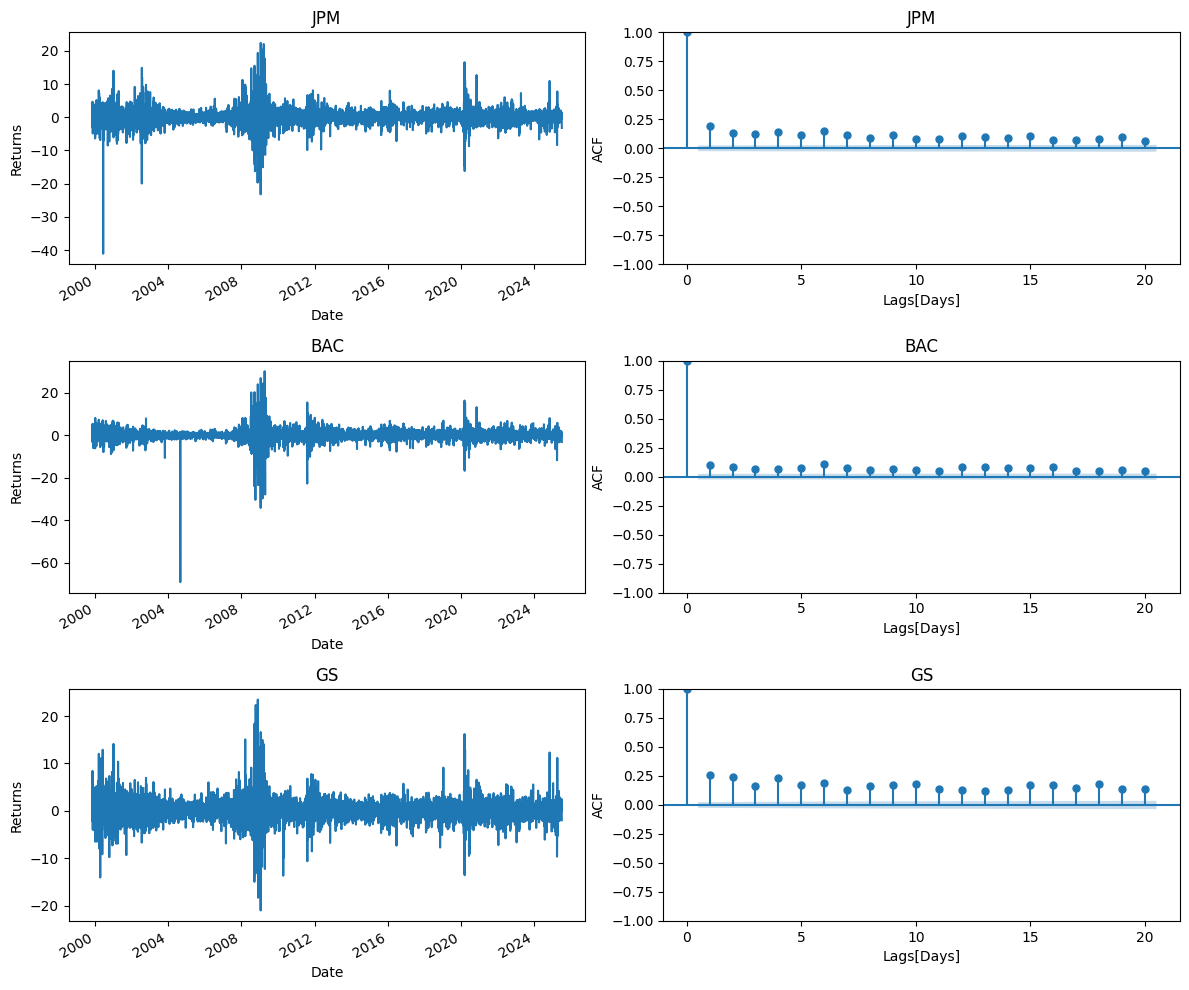

In [8]:
finance_data = get_stock_data(finance)
plot_stock_data(finance_data, feature='returns')

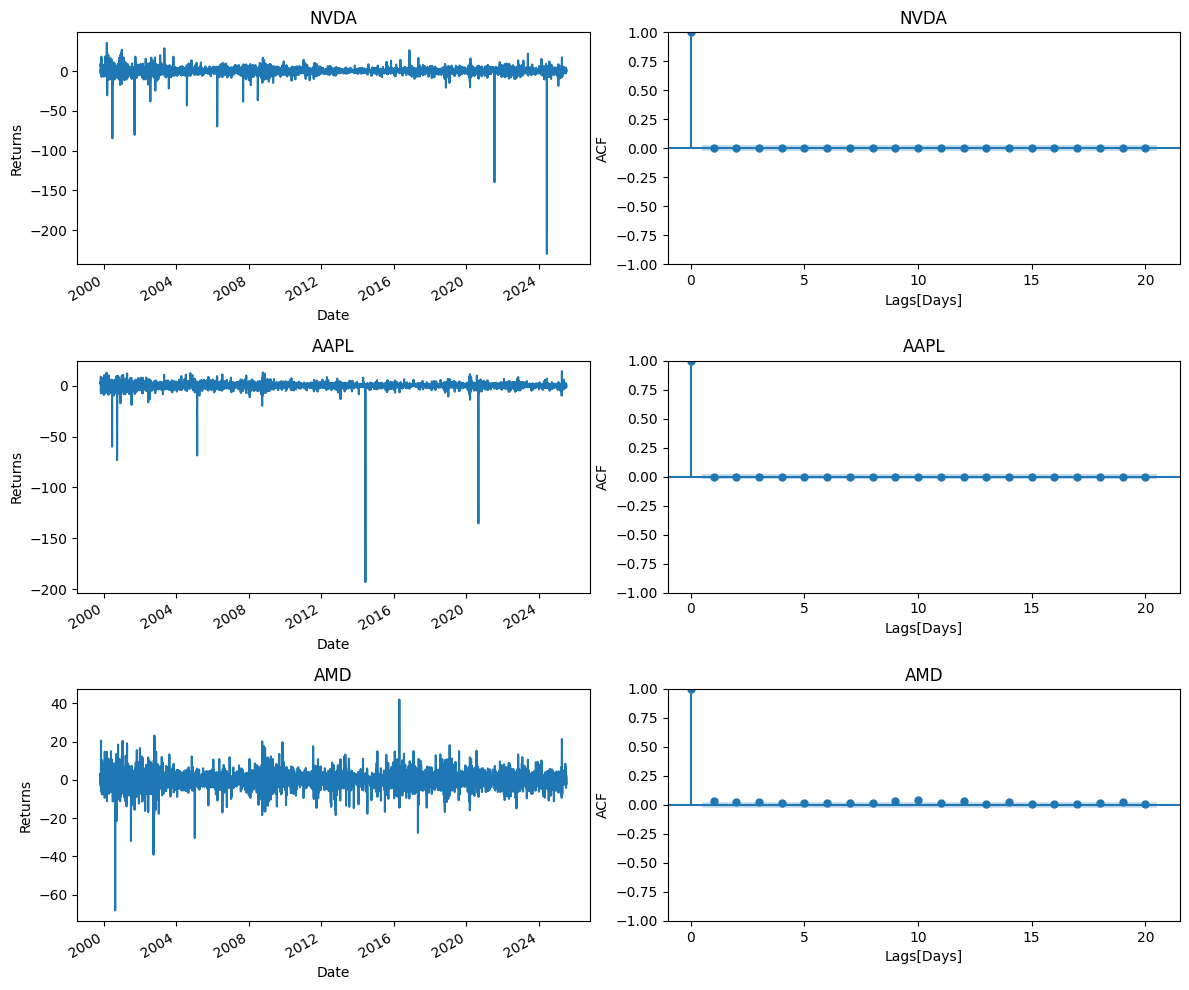

In [9]:
tech_data = get_stock_data(tech)
plot_stock_data(tech_data, feature='returns')

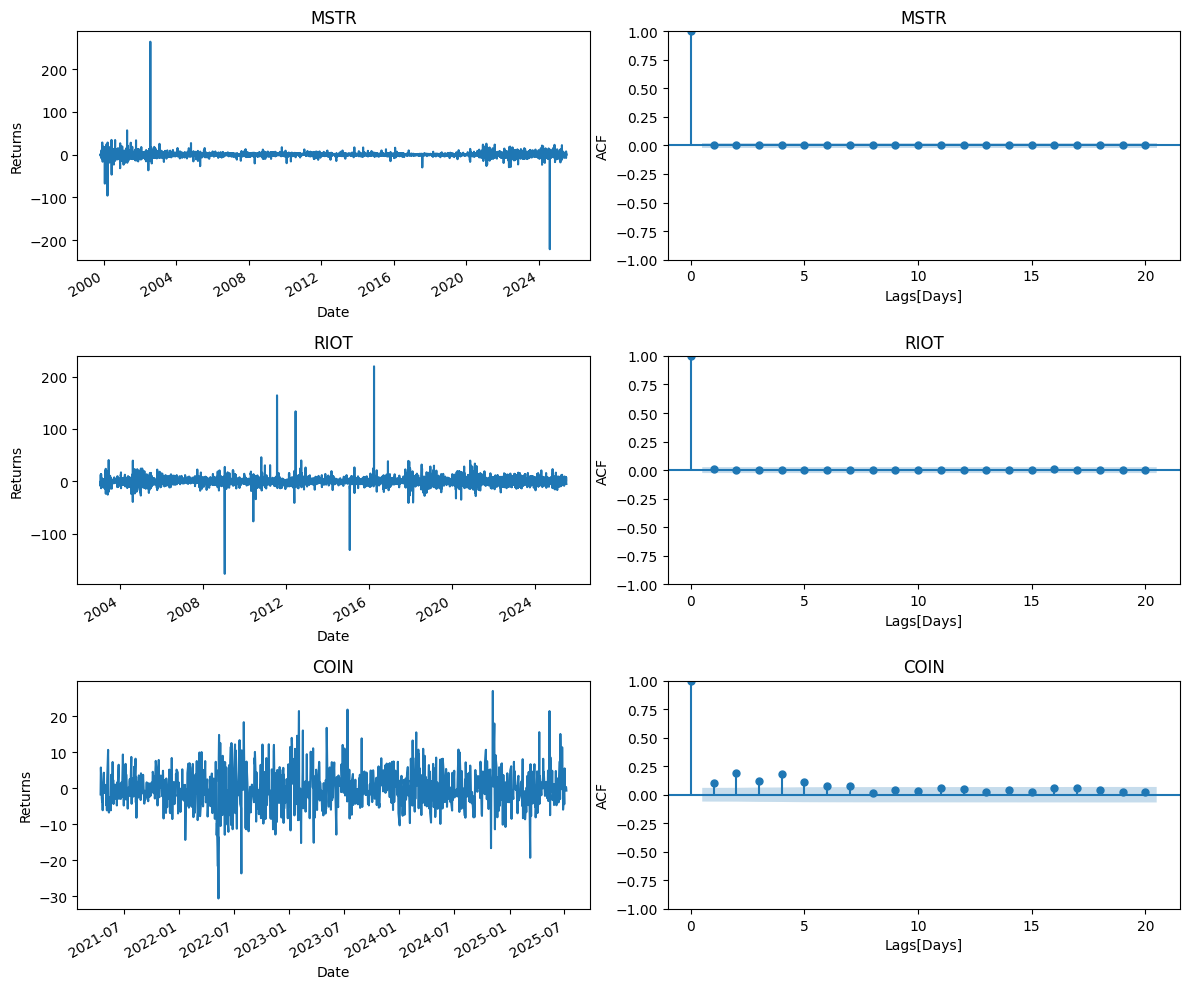

In [10]:
crypto_data = get_stock_data(crypto)
plot_stock_data(crypto_data, feature='returns')

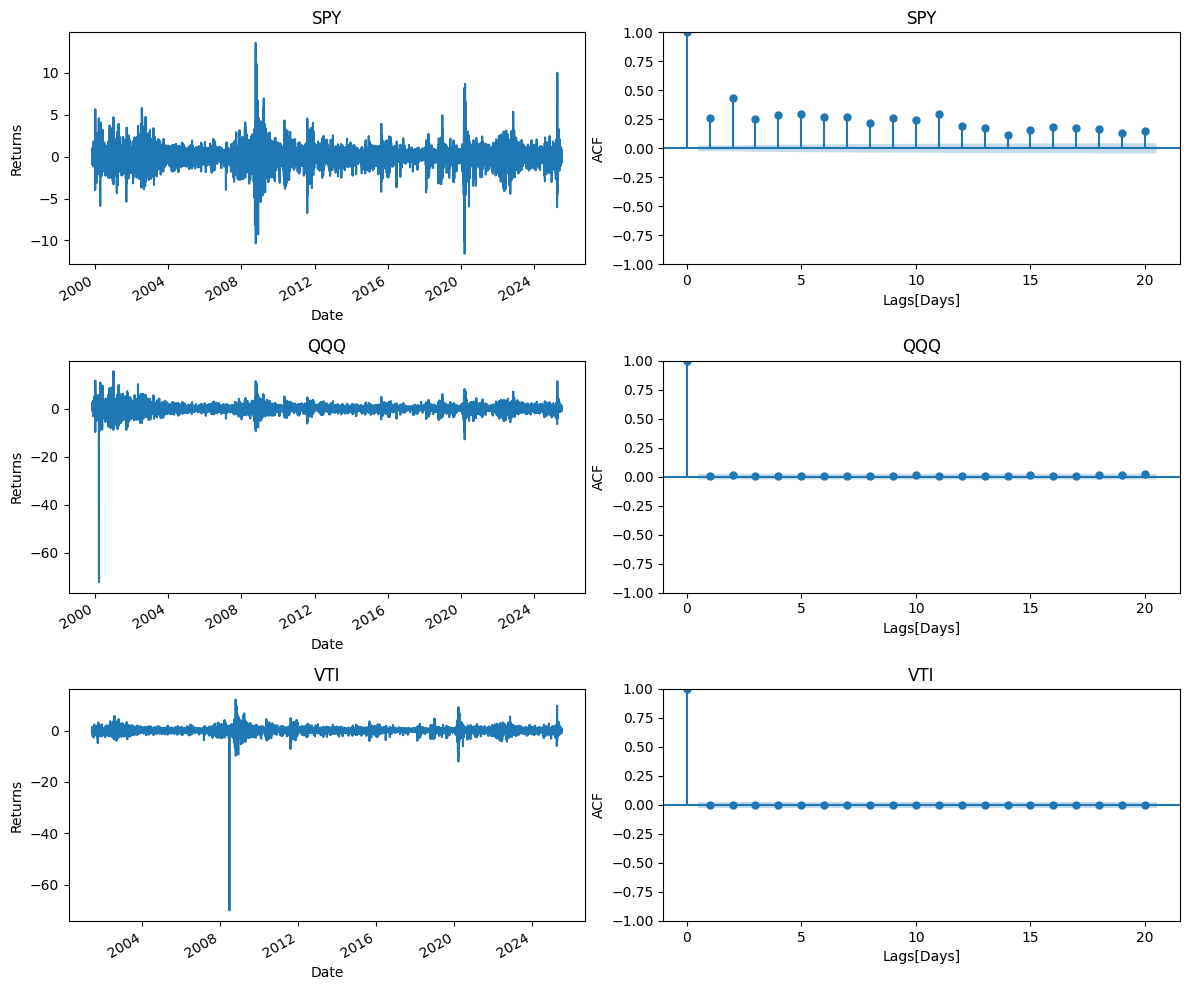

In [11]:
etf_data = get_stock_data(etf)
plot_stock_data(etf_data, feature='returns')

In [21]:
def clustering_score(df, lags=10):
    scores = {}
    for stock in df:
        clustering_values = acf(df[stock]['returns']**2, nlags=lags)
        scores[stock] = np.sum(np.abs(clustering_values[1:lags+1]))  # Exclude lag 0
    return scores

In [25]:
clustering_values = acf(etf_data['SPY']['returns']**2, nlags=5)
scores = np.sum(np.abs(clustering_values[1:5+1]))  # Exclude lag 0


In [26]:
clustering_values

array([1.        , 0.26360677, 0.4365197 , 0.2496531 , 0.2854378 ,
       0.29283696])

In [22]:
clustering_scores = clustering_score(etf_data, lags=5)

In [23]:
df_clustering_score=pd.DataFrame(clustering_scores.items(), columns=['Stock', 'C Score']).sort_values(by='C Score', ascending=False).set_index('Stock')
df_clustering_score

,C Score
Stock,
SPY,1.528054
QQQ,0.034272
VTI,0.009821


In [17]:
etf_data['SPY']

,open,high,low,close,volume,returns
date,,,,,,
1999-11-02,135.9687,137.2500,134.5937,134.5937,6516900.0,-0.717218
1999-11-03,136.0000,136.3750,135.1250,135.5000,7222300.0,0.671103
1999-11-04,136.7500,137.3593,135.7656,136.5312,7907500.0,0.758152
1999-11-05,138.6250,139.1093,136.7812,137.8750,7431500.0,0.979432
1999-11-08,137.0000,138.3750,136.7500,138.0000,4649200.0,0.090621
...,...,...,...,...,...,...
2025-07-01,616.3600,618.8300,615.5200,617.6500,70030140.0,-0.032376
2025-07-02,617.2400,620.4900,616.6100,620.4500,66510374.0,0.452307
2025-07-03,622.4500,626.2800,622.4300,625.3400,51065789.0,0.785048


# GARCH walk forward

In [ ]:
class GARCHWalkForward:
    def __init__(self, stock_data, train_size=0.8):
        self.stock_data = stock_data
        self.train_size = train_size

    def train_test_split(self):
        cutoff = int(len(self.stock_data) * self.train_size)
        y_test = self.stock_data["returns"].iloc[cutoff:]
        return y_test
    
    def fit_garch(self):
        y_test = self.train_test_split()
        w_fwd_pred =[]
        for i in range(len(y_test)):
            y_train = self.stock_data["returns"].iloc[1:-(len(y_test)-i)]
            model = arch_model(y_train, vol='EGARCH', p=1, q=1, rescale=False)
            res= model.fit(disp=0)
            params_dict = res.params.to_dict()
            forecasts = res.forecast(horizon=1)
            pred_vol = (forecasts.variance.values[-1,:][0])**0.5
            w_fwd_pred.append(pred_vol)
        return w_fwd_pred, params_dict
    
    def plot_results(self,  w_fwd_pred):
        y_test = self.train_test_split()
        w_fwd_vol= pd.Series(w_fwd_pred, index=y_test.index, name='Predicted Volatility')
        test_vol= self.stock_data['returns'].rolling(window=21).std().dropna()
        test_vol=test_vol.iloc[-len(y_test):]
        plt.figure(figsize=(10, 6))
        plt.plot(y_test.index, y_test, color='lightgray', label='Log Returns')
        plt.plot(y_test.index, w_fwd_vol, color='black', label='Predicted Volatility')
        plt.plot(test_vol.index, test_vol, color='red', label='Actual Volatility')
        plt.legend()
        plt.title('GARCH Model Walk Forward Prediction')
        plt.xlabel('Date')
        plt.ylabel('Volatility')
        plt.show()

    def evaluate_model(self, w_fwd_pred):
        y_test = self.train_test_split()
        w_fwd_vol = pd.Series(w_fwd_pred, index=y_test.index, name='Predicted Volatility')
        test_vol = self.stock_data['returns'].rolling(window=21).std().dropna()
        test_vol = test_vol.iloc[-len(y_test):]
        
        r2 = r2_score(test_vol, w_fwd_vol)
        mae = mean_absolute_error(test_vol, w_fwd_vol)
        mse = mean_squared_error(test_vol, w_fwd_vol)
        
        print(f"R^2: {r2:.4f}, MAE: {mae:.4f}, MSE: {mse:.4f}")


In [303]:
class GARCHWalkForward:
    def __init__(self, stock_data, train_size=0.8):
        self.stock_data = stock_data
        self.train_size = train_size

    def train_test_split(self):
        cutoff = int(len(self.stock_data) * self.train_size)
        y_test = self.stock_data["returns"].iloc[cutoff:]
        return y_test
    
    def fit_garch(self):
        y_test = self.train_test_split()
        w_fwd_pred =[]
        resids = []
        for i in range(len(y_test)):
            y_train = self.stock_data["returns"].iloc[0:-(len(y_test)-i)]
            model = arch_model(y_train, vol='GARCH', p=1, q=1, rescale=False)
            res= model.fit(disp=0)
            params_dict = res.params.to_dict()
            forecasts = res.forecast(horizon=1)
            pred_vol = (forecasts.variance.values[-1,:][0])**0.5
            w_fwd_pred.append(pred_vol)
            
            # calculate residuals
            actual_return = self.stock_data['returns'].iloc[-(len(y_test)-i)]
            z = actual_return/ pred_vol
            resids.append(z)
        return w_fwd_pred, params_dict, resids

    def plot_results(self,  w_fwd_pred):
        y_test = self.train_test_split()
        w_fwd_vol= pd.Series(w_fwd_pred, index=y_test.index, name='Predicted Volatility')
        test_vol= self.stock_data['returns'].rolling(window=21).std().dropna()
        test_vol=test_vol.iloc[-len(y_test):]
        plt.figure(figsize=(10, 6))
        plt.plot(y_test.index, y_test, color='lightgray', label='Log Returns')
        plt.plot(y_test.index, w_fwd_vol, color='black', label='Predicted Volatility')
        plt.plot(test_vol.index, test_vol, color='red', label='Actual Volatility')
        plt.legend()
        plt.title('GARCH Model Walk Forward Prediction')
        plt.xlabel('Date')
        plt.ylabel('Volatility')
        plt.show()

    def evaluate_model(self, w_fwd_pred):
        y_test = self.train_test_split()
        w_fwd_vol = pd.Series(w_fwd_pred, index=y_test.index, name='Predicted Volatility')
        test_vol = self.stock_data['returns'].rolling(window=21).std().dropna()
        test_vol = test_vol.iloc[-len(y_test):]
        
        r2 = r2_score(test_vol, w_fwd_vol)
        mae = mean_absolute_error(test_vol, w_fwd_vol)
        mse = mean_squared_error(test_vol, w_fwd_vol)
        
        print(f"R^2: {r2:.4f}, MAE: {mae:.4f}, MSE: {mse:.4f}")

In [258]:
class GARCHWalkForward:
    def __init__(self, stock_data, train_size=0.8):
        self.stock_data = stock_data
        self.train_size = train_size

    def train_test_split(self):
        cutoff = int(len(self.stock_data) * self.train_size)
        y_test = self.stock_data["returns"].iloc[cutoff:]
        return y_test
    
    def fit_garch(self):
        y_test = self.train_test_split()
        w_fwd_pred =[]
        resids = []
        for i in range(len(y_test)):
            y_train = self.stock_data["returns"].iloc[0:-(len(y_test)-i)]
            model = arch_model(y_train, vol='GARCH', p=1, q=1, rescale=False)
            res= model.fit(disp=0)
            params_dict = res.params.to_dict()
            forecasts = res.forecast(horizon=1)
            pred_vol = forecasts.variance.values[-1,:][0]
            w_fwd_pred.append(pred_vol)
            
            # calculate residuals
            actual_return = self.stock_data['returns'].iloc[-(len(y_test)-i)]
            z = actual_return/ pred_vol
            resids.append(z)
        return w_fwd_pred, params_dict, resids

    def plot_results(self,  w_fwd_pred):
        y_test = self.train_test_split()
        w_fwd_vol= pd.Series(w_fwd_pred, index=y_test.index, name='Predicted Volatility')
        test_vol= self.stock_data['returns']**2
        test_vol=test_vol.iloc[-len(y_test):]
        plt.figure(figsize=(10, 6))
        plt.plot(y_test.index, y_test**2, color='lightgray', label='Log Returns')
        plt.plot(y_test.index, w_fwd_vol, color='black', label='Predicted Volatility')
        plt.plot(test_vol.index, test_vol, color='red', label='Actual Volatility')
        plt.legend()
        plt.title('GARCH Model Walk Forward Prediction')
        plt.xlabel('Date')
        plt.ylabel('Volatility')
        plt.show()

    def evaluate_model(self, w_fwd_pred):
        y_test = self.train_test_split()
        w_fwd_vol = pd.Series(w_fwd_pred, index=y_test.index, name='Predicted Volatility')
        test_vol = self.stock_data['returns']**2
        test_vol = test_vol.iloc[-len(y_test):]
        
        r2 = r2_score(test_vol, w_fwd_vol)
        mae = mean_absolute_error(test_vol, w_fwd_vol)
        mse = mean_squared_error(test_vol, w_fwd_vol)
        
        print(f"R^2: {r2:.4f}, MAE: {mae:.4f}, MSE: {mse:.4f}")

In [66]:
class GARCHWalkForward:
    def __init__(self, stock_data, train_size=0.8):
        self.stock_data = stock_data
        self.train_size = train_size

    def train_test_split(self):
        cutoff = int(len(self.stock_data) * self.train_size)
        y_test = self.stock_data["returns"].iloc[cutoff:]
        return y_test
    
    def fit_garch(self):
        y_test = self.train_test_split()
        w_fwd_pred =[]
        resids = []
        for i in range(len(y_test)):
            y_train = self.stock_data["returns"].iloc[0:-(len(y_test)-i)]
            model = arch_model(y_train, vol='GARCH', p=1, q=1, rescale=False)
            res= model.fit(disp=0)
            params_dict = res.params.to_dict()
            forecasts = res.forecast(horizon=1)
            pred_vol = (forecasts.variance.values[-1,:][0])**0.5
            w_fwd_pred.append(pred_vol)
            
            # calculate residuals
            actual_return = self.stock_data['returns'].iloc[-(len(y_test)-i)]
            z = actual_return/ pred_vol
            resids.append(z)
        return w_fwd_pred, params_dict, resids

    def plot_results(self,  w_fwd_pred):
        y_test = self.train_test_split()
        w_fwd_vol= pd.Series(w_fwd_pred, index=y_test.index, name='Predicted Volatility')
        test_vol= (1/(4*np.log(2))*(((np.log(self.stock_data['high']/self.stock_data['low'])*100)**2)).rolling(window=1).mean())
        test_vol=np.sqrt(test_vol).iloc[-len(y_test):]
        plt.figure(figsize=(10, 6))
        plt.plot(y_test.index, y_test, color='lightgray', label='Log Returns')
        plt.plot(y_test.index, w_fwd_vol, color='black', label='Predicted Volatility')
        plt.plot(test_vol.index, test_vol, color='red', label='Actual Volatility')
        plt.legend()
        plt.title('GARCH Model Walk Forward Prediction')
        plt.xlabel('Date')
        plt.ylabel('Volatility')
        plt.show()


    def evaluate_model(self, w_fwd_pred):
        y_test = self.train_test_split()
        w_fwd_vol = pd.Series(w_fwd_pred, index=y_test.index, name='Predicted Volatility')
        test_vol = (1/(4*np.log(2))*(((np.log(self.stock_data['high']/self.stock_data['low'])*100)**2)).rolling(window=1).mean())
        test_vol = np.sqrt(test_vol).iloc[-len(y_test):]
        
        mae = mean_absolute_error(test_vol, w_fwd_vol)
        mse = mean_squared_error(test_vol, w_fwd_vol)
        rmse = np.sqrt(mse)
        qlike = np.mean(np.log(w_fwd_vol**2)+(test_vol/w_fwd_vol)**2)

        print(f"MAE: {mae:.4f}, MSE: {mse:.4f}, RMSE: {rmse:.4f}, QLIKE: {qlike:.4f}")

In [67]:
class HVmodel:
    def __init__(self, stock_data, train_size=0.8):
        self.stock_data = stock_data
        self.train_size = train_size

    def train_test_split(self):
        cutoff = int(len(self.stock_data) * self.train_size)
        y_test = self.stock_data["returns"].iloc[cutoff:]
        return y_test
    
    def HVpred(self):
        y_test = self.train_test_split()
        hv=self.stock_data['returns'].rolling(window=21).std().shift(1).dropna()
        hv=hv.iloc[-len(y_test):]
    
        return hv

    def plot_results(self,  hv):
        y_test = self.train_test_split()
        h_vol= pd.Series(hv, index=y_test.index, name='Predicted Volatility')
        test_vol= (1/(4*np.log(2))*(((np.log(self.stock_data['high']/self.stock_data['low'])*100)**2)).rolling(window=1).mean())
        test_vol=np.sqrt(test_vol).iloc[-len(y_test):]
        plt.figure(figsize=(10, 6))
        plt.plot(y_test.index, y_test, color='lightgray', label='Log Returns')
        plt.plot(y_test.index, h_vol, color='black', label='Predicted Volatility')
        plt.plot(test_vol.index, test_vol, color='red', label='Actual Volatility')
        plt.legend()
        plt.title('GARCH Model Walk Forward Prediction')
        plt.xlabel('Date')
        plt.ylabel('Volatility')
        plt.show()


    def evaluate_model(self, hv):
        y_test = self.train_test_split()
        h_vol = pd.Series(hv, index=y_test.index, name='Predicted Volatility')
        test_vol = (1/(4*np.log(2))*(((np.log(self.stock_data['high']/self.stock_data['low'])*100)**2)).rolling(window=1).mean())
        test_vol = np.sqrt(test_vol).iloc[-len(y_test):]
        
        mae = mean_absolute_error(test_vol, h_vol)
        mse = mean_squared_error(test_vol, h_vol)
        rmse = np.sqrt(mse)
        qlike = np.mean(np.log(h_vol**2)+(test_vol/h_vol)**2)

        print(f"MAE: {mae:.4f}, MSE: {mse:.4f}, RMSE: {rmse:.4f}, QLIKE: {qlike:.4f}")

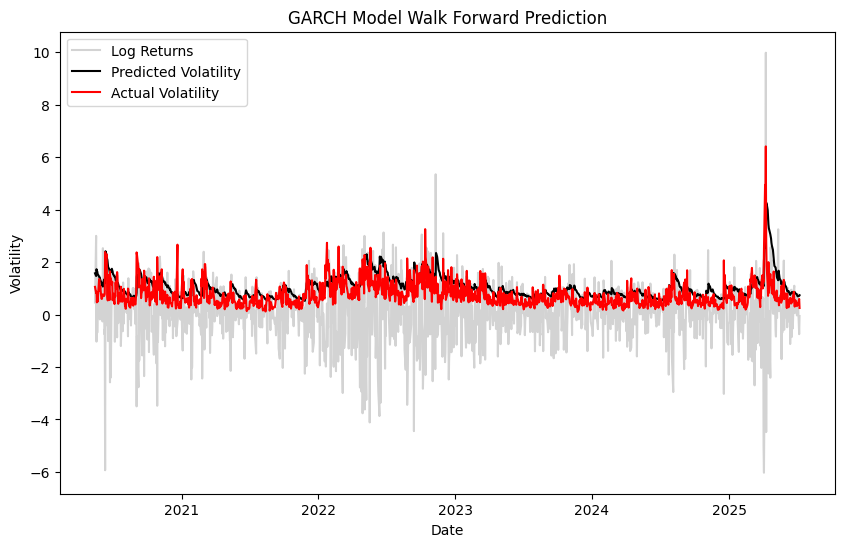

MAE: 0.4170, MSE: 0.2853, RMSE: 0.5341, QLIKE: 0.6235


In [37]:
SPY_garch = GARCHWalkForward(etf_data['SPY'])
w_fwd_pred, params_dict, resids = SPY_garch.fit_garch()
SPY_garch.plot_results(w_fwd_pred)
SPY_garch.evaluate_model(w_fwd_pred)

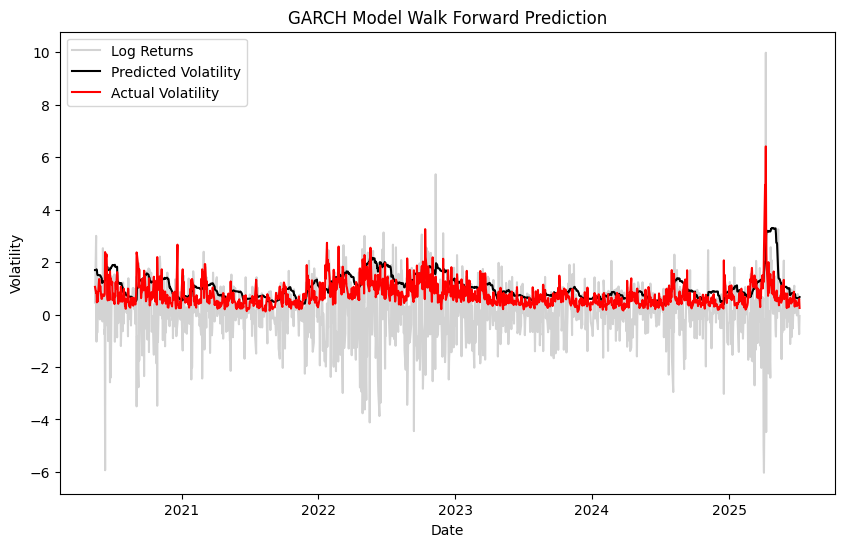

MAE: 0.4317, MSE: 0.3388, RMSE: 0.5820, QLIKE: 0.6701


In [68]:
SPY_hv = HVmodel(etf_data['SPY'])
hv = SPY_hv.HVpred()
SPY_hv.plot_results(hv)
SPY_hv.evaluate_model(hv)

In [310]:
lb_test = acorr_ljungbox(resids, lags=[10], return_df=True)
print(lb_test)

     lb_stat  lb_pvalue
10  7.540525   0.673619


In [311]:
arch_test = het_arch(np.array(resids), nlags=10)
print(f"LM Stat: {arch_test[0]}, p-value: {arch_test[1]}")

LM Stat: 13.866508630352646, p-value: 0.1791681081875992


In [312]:
jb_stat, jb_pvalue = jarque_bera(resids)
print(f"JB Statistic: {jb_stat}, p-value: {jb_pvalue}")

JB Statistic: 282.3132123651511, p-value: 4.971241377451462e-62


In [313]:
params_dict

{'mu': 0.06329694447212655,
 'omega': 0.025436601411090557,
 'alpha[1]': 0.12591888441375618,
 'beta[1]': 0.8565876275475165}

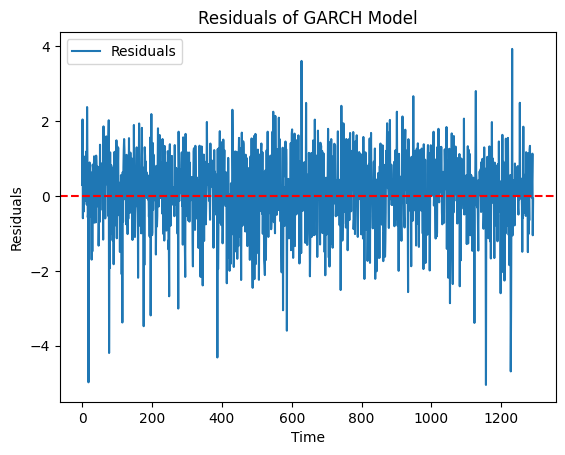

In [314]:
plt.plot(resids, label='Residuals')
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals of GARCH Model')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.legend()
plt.show()

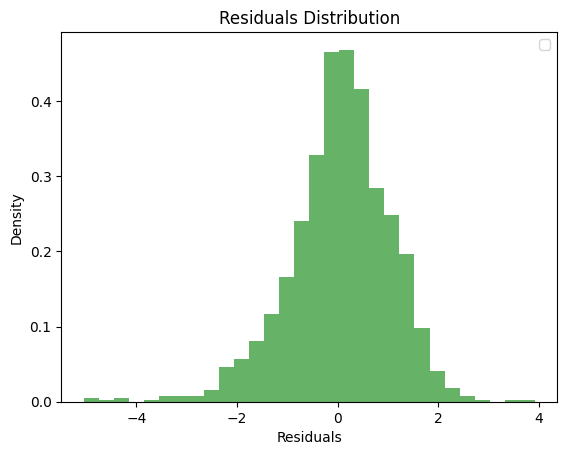

In [315]:
plt.hist(resids, bins=30, density=True, alpha=0.6, color='g')
plt.title('Residuals Distribution')
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.legend()
plt.show()

In [316]:
print(np.mean(resids))
print(np.std(resids))

0.054689724057975175
1.017545531495266


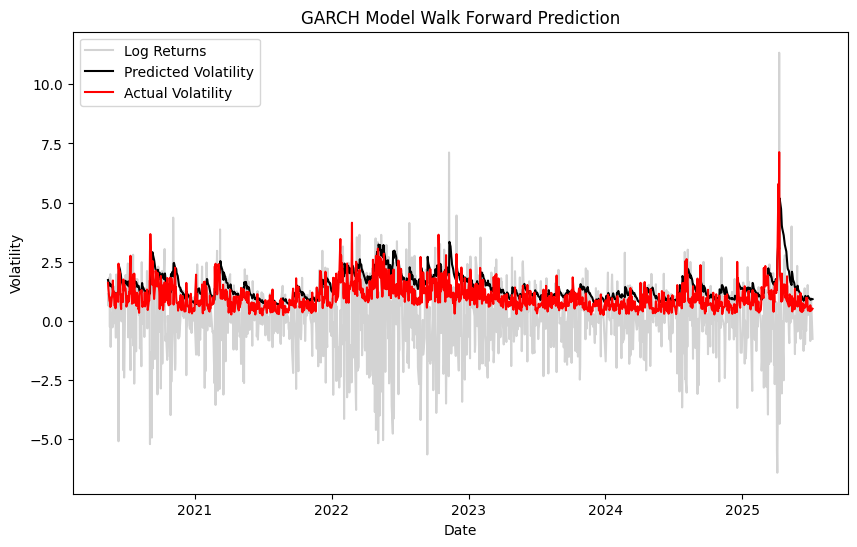

MAE: 0.5576, MSE: 0.4918, RMSE: 0.7013, QLIKE: 1.2325


In [39]:
QQQ_garch = GARCHWalkForward(etf_data['QQQ'])
w_fwd_pred, params_dict, resids = QQQ_garch.fit_garch()
QQQ_garch.plot_results(w_fwd_pred)
QQQ_garch.evaluate_model(w_fwd_pred)

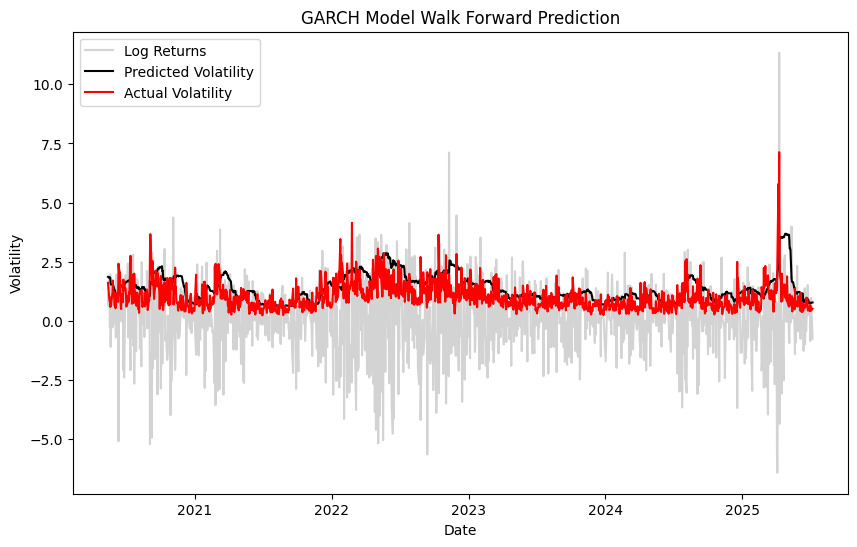

MAE: 0.5373, MSE: 0.4987, RMSE: 0.7062, QLIKE: 1.2351


In [69]:
QQQ_hv = HVmodel(etf_data['QQQ'])
hv = QQQ_hv.HVpred()
QQQ_hv.plot_results(hv)
QQQ_hv.evaluate_model(hv)

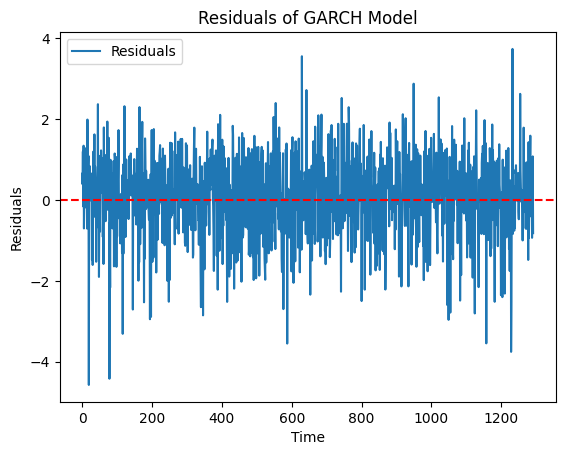

In [318]:
plt.plot(resids, label='Residuals')
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals of GARCH Model')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.legend()
plt.show()

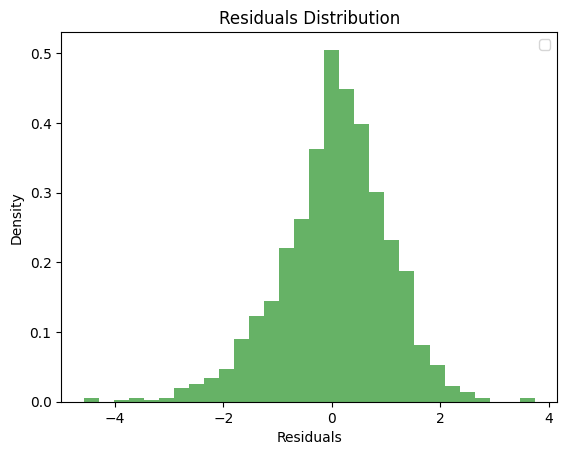

In [319]:
plt.hist(resids, bins=30, density=True, alpha=0.6, color='g')
plt.title('Residuals Distribution')
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.legend()
plt.show()

In [320]:
print(np.mean(resids))
print(np.std(resids))

0.05368737243296071
0.9991863399205593


/Users/susmitasingh/Documents/Documents/job_prep/projects/stock_project/.venv/lib/python3.9/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/susmitasingh/Documents/Documents/job_prep/projects/stock_project/.venv/lib/python3.9/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/susmitasingh/Documents/Documents/job_prep/projects/stock_project/.venv/lib/python3.9/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/susmitasingh/Documents/Documents/job_prep/projec

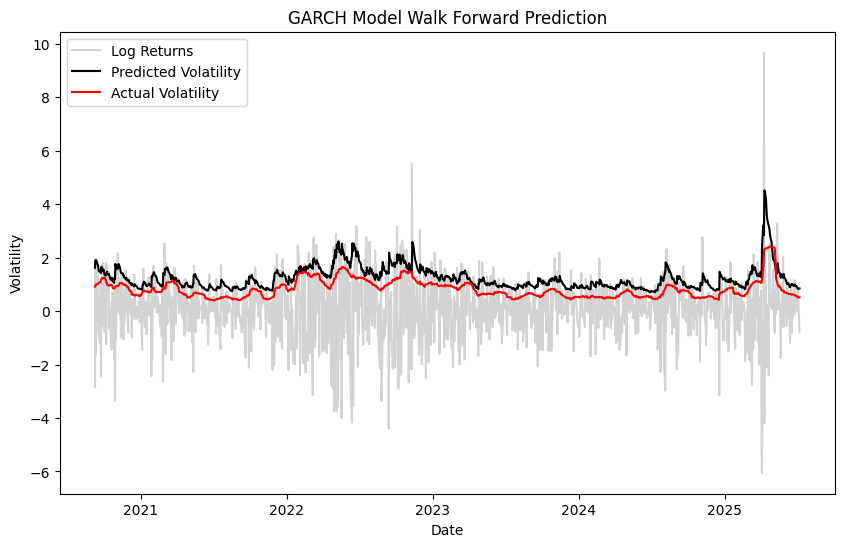

R^2: -0.7099, MAE: 0.4085, MSE: 0.2083


In [19]:
VTI_garch = GARCHWalkForward(etf_data['VTI'])
w_fwd_pred, params_dict, resids = VTI_garch.fit_garch()
VTI_garch.plot_results(w_fwd_pred)
VTI_garch.evaluate_model(w_fwd_pred)

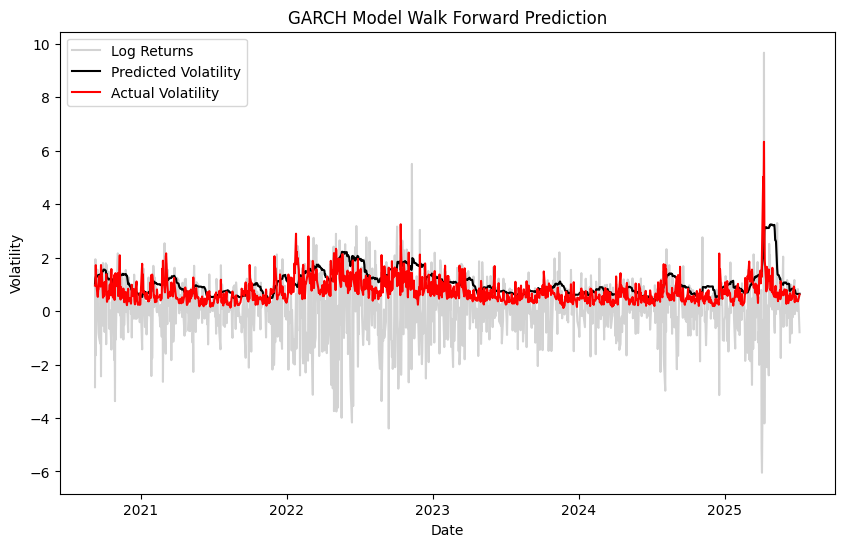

MAE: 0.4344, MSE: 0.3383, RMSE: 0.5816, QLIKE: 0.6638


In [70]:
VTI_hv = HVmodel(etf_data['VTI'])
hv = VTI_hv.HVpred()
VTI_hv.plot_results(hv)
VTI_hv.evaluate_model(hv)

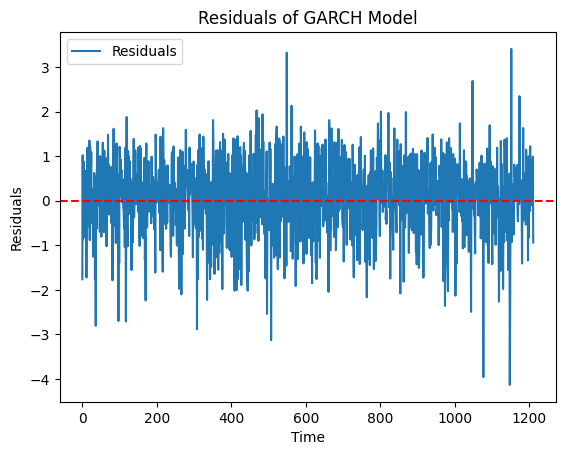

In [186]:
plt.plot(resids, label='Residuals')
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals of GARCH Model')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.legend()
plt.show()

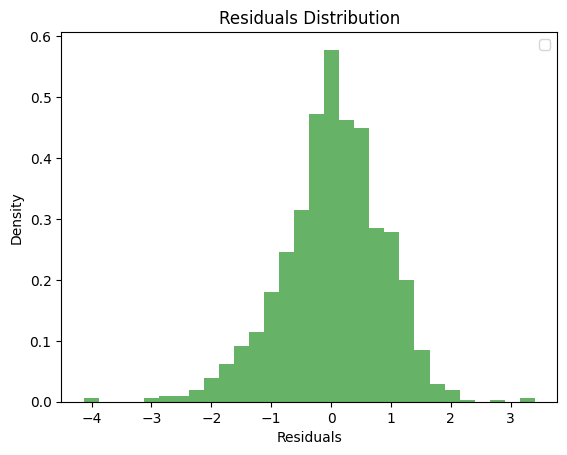

In [187]:
plt.hist(resids, bins=30, density=True, alpha=0.6, color='g')
plt.title('Residuals Distribution')
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.legend()
plt.show()

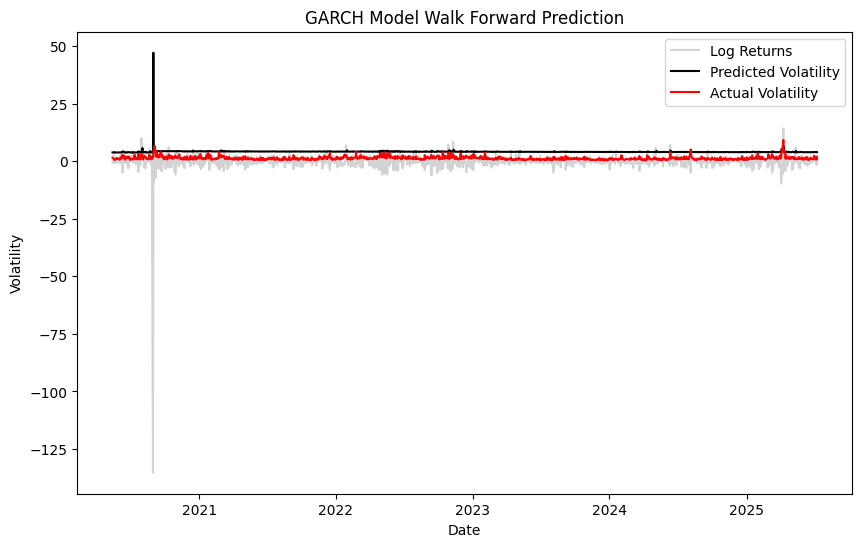

MAE: 2.8658, MSE: 9.9940, RMSE: 3.1613, QLIKE: 2.9763


In [41]:
AAPL_garch = GARCHWalkForward(tech_data['AAPL'])
w_fwd_pred, params_dict, resids = AAPL_garch.fit_garch()
AAPL_garch.plot_results(w_fwd_pred)
AAPL_garch.evaluate_model(w_fwd_pred)   

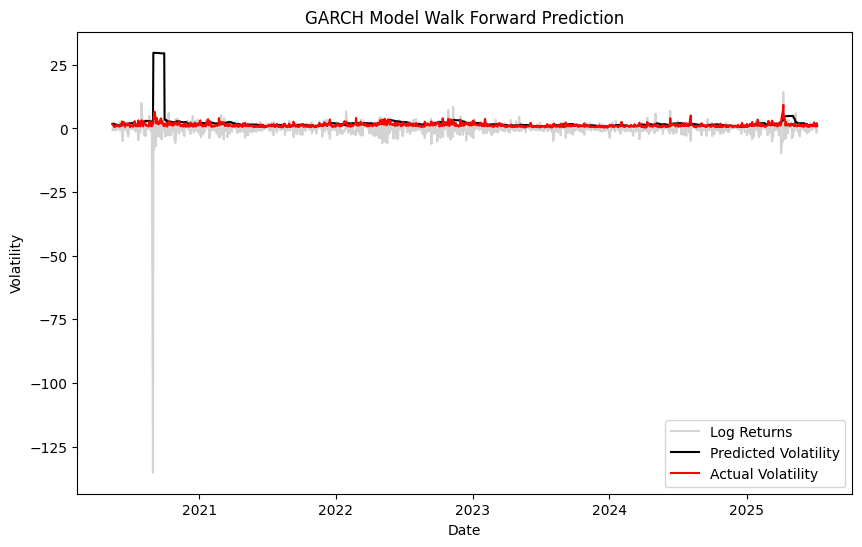

MAE: 1.0868, MSE: 12.4953, RMSE: 3.5349, QLIKE: 1.8401


In [71]:
AAPL_hv = HVmodel(tech_data['AAPL'])
hv = AAPL_hv.HVpred()
AAPL_hv.plot_results(hv)
AAPL_hv.evaluate_model(hv)

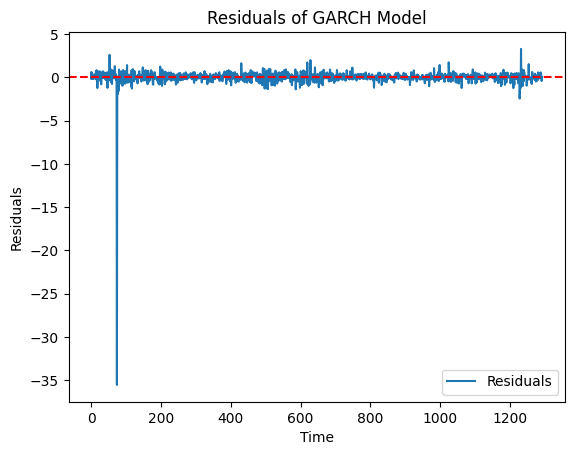

In [322]:
plt.plot(resids, label='Residuals')
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals of GARCH Model')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.legend()
plt.show()

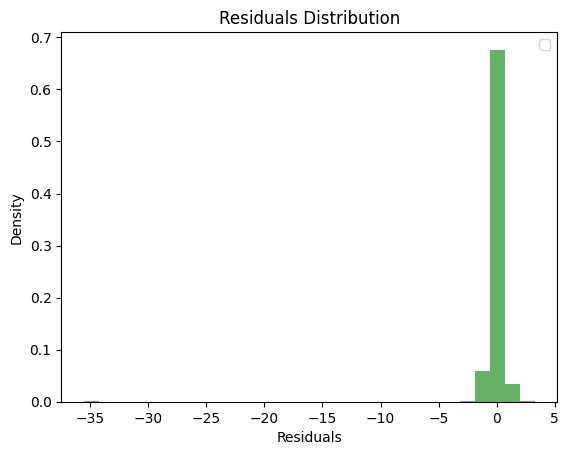

In [323]:
plt.hist(resids, bins=30, density=True, alpha=0.6, color='g')
plt.title('Residuals Distribution')
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.legend()
plt.show()  

In [324]:
print(np.mean(resids))
print(np.std(resids))

-0.009035005373152516
1.0850285669496866


In [325]:
params_dict

{'mu': 0.011459484867062596,
 'omega': 15.445963096588573,
 'alpha[1]': 0.13194019932788878,
 'beta[1]': 4.75849310253276e-13}

/Users/susmitasingh/Documents/Documents/job_prep/projects/stock_project/.venv/lib/python3.9/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/susmitasingh/Documents/Documents/job_prep/projects/stock_project/.venv/lib/python3.9/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/susmitasingh/Documents/Documents/job_prep/projects/stock_project/.venv/lib/python3.9/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/susmitasingh/Documents/Documents/job_prep/projec

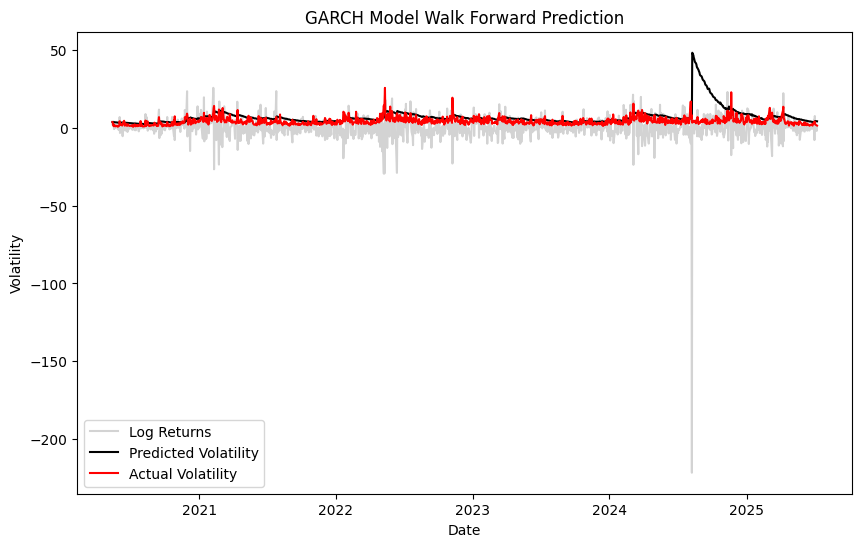

MAE: 3.3126, MSE: 36.0554, RMSE: 6.0046, QLIKE: 4.1582


In [75]:
MSTR_garch = GARCHWalkForward(crypto_data['MSTR'])
w_fwd_pred, params_dict, resids = MSTR_garch.fit_garch()
MSTR_garch.plot_results(w_fwd_pred)
MSTR_garch.evaluate_model(w_fwd_pred)   

In [76]:
MSTR_hv = HVmodel(crypto_data['MSTR'])
hv = MSTR_hv.HVpred()
# MSTR_hv.plot_results(hv)
MSTR_hv.evaluate_model(hv)

MAE: 2.7962, MSE: 39.5052, RMSE: 6.2853, QLIKE: 4.0762


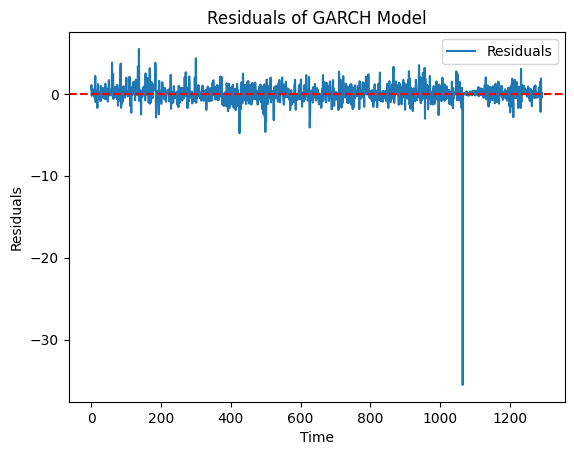

In [215]:
plt.plot(resids, label='Residuals')
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals of GARCH Model')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.legend()
plt.show()

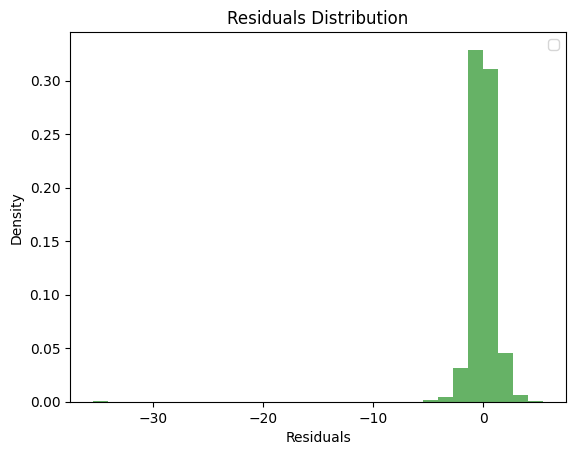

In [216]:
plt.hist(resids, bins=30, density=True, alpha=0.6, color='g')
plt.title('Residuals Distribution')
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.legend()
plt.show()  

In [217]:
print(np.mean(resids))

0.021869657046311136


In [218]:
print(np.std(resids))

1.382597082248878


In [219]:
params_dict

{'mu': 0.13803416526758155,
 'omega': 0.12044479358658819,
 'alpha[1]': 0.05084199262276423,
 'beta[1]': 0.9491580073772334}

In [224]:
lb_test = acorr_ljungbox(resids, lags=[10], return_df=True)
print(lb_test)

     lb_stat  lb_pvalue
10  7.546461   0.673043


In [237]:
arch_test = het_arch(np.array(resids), nlags=10)
print(f"LM Stat: {arch_test[0]}, p-value: {arch_test[1]}")

LM Stat: 0.028044960582535028, p-value: 0.9999999999955345


In [239]:
jb_stat, jb_pvalue = jarque_bera(resids)
print(f"JB Statistic: {jb_stat}, p-value: {jb_pvalue}")

JB Statistic: 6143923.908947771, p-value: 0.0


In [276]:
etf_data['SPY']

,open,high,low,close,volume,returns
date,,,,,,
1999-11-02,135.9687,137.2500,134.5937,134.5937,6516900.0,-0.717218
1999-11-03,136.0000,136.3750,135.1250,135.5000,7222300.0,0.671103
1999-11-04,136.7500,137.3593,135.7656,136.5312,7907500.0,0.758152
1999-11-05,138.6250,139.1093,136.7812,137.8750,7431500.0,0.979432
1999-11-08,137.0000,138.3750,136.7500,138.0000,4649200.0,0.090621
...,...,...,...,...,...,...
2025-07-01,616.3600,618.8300,615.5200,617.6500,70030140.0,-0.032376
2025-07-02,617.2400,620.4900,616.6100,620.4500,66510374.0,0.452307
2025-07-03,622.4500,626.2800,622.4300,625.3400,51065789.0,0.785048


In [286]:
1/(4*np.log(2))*(((np.log(etf_data['SPY']['high']/etf_data['SPY']['low'])*100)**2).rolling(window=21).mean())

date
1999-11-02         NaN
1999-11-03         NaN
1999-11-04         NaN
1999-11-05         NaN
1999-11-08         NaN
                ...   
2025-07-01    0.276665
2025-07-02    0.253833
2025-07-03    0.247070
2025-07-07    0.261053
2025-07-08    0.233382
Length: 6458, dtype: float64

In [285]:
(etf_data['SPY']['returns']).rolling(window=21).mean()

date
1999-11-02         NaN
1999-11-03         NaN
1999-11-04         NaN
1999-11-05         NaN
1999-11-08         NaN
                ...   
2025-07-01    0.223018
2025-07-02    0.217808
2025-07-03    0.228114
2025-07-07    0.193774
2025-07-08    0.214157
Name: returns, Length: 6458, dtype: float64

In [48]:
etf_data['SPY']['volatility'] = etf_data['SPY']['returns'].rolling(window=3).std()
etf_data['SPY']['hv_pred'] = etf_data['SPY']['volatility'].shift(1)


In [49]:
etf_data['SPY']

,open,high,low,close,volume,returns,volatility,hv_pred
date,,,,,,,,
1999-11-02,135.9687,137.2500,134.5937,134.5937,6516900.0,-0.717218,NaN,NaN
1999-11-03,136.0000,136.3750,135.1250,135.5000,7222300.0,0.671103,NaN,NaN
1999-11-04,136.7500,137.3593,135.7656,136.5312,7907500.0,0.758152,0.827821,NaN
1999-11-05,138.6250,139.1093,136.7812,137.8750,7431500.0,0.979432,0.158960,0.827821
1999-11-08,137.0000,138.3750,136.7500,138.0000,4649200.0,0.090621,0.462700,0.158960
...,...,...,...,...,...,...,...,...
2025-07-01,616.3600,618.8300,615.5200,617.6500,70030140.0,-0.032376,0.299598,0.169445
2025-07-02,617.2400,620.4900,616.6100,620.4500,66510374.0,0.452307,0.287219,0.299598
2025-07-03,622.4500,626.2800,622.4300,625.3400,51065789.0,0.785048,0.411059,0.287219


In [23]:
print(np.std([-0.717218,	0.671103]))

0.6941605


In [34]:
print(np.sqrt(np.std([-0.717218,	0.671103,  0.758152])))

0.8221394781656478


In [26]:
print(np.std([0.671103,  0.758152, 0.979432]))

0.12979006084271458


In [47]:
print(np.std(list(etf_data['SPY']['returns'].iloc[0:3]),ddof=1))

0.8278212246649834


In [33]:
list(etf_data['SPY']['returns'].iloc[0:3])

[-0.7172177821052932, 0.67110295537153, 0.7581519615361311]

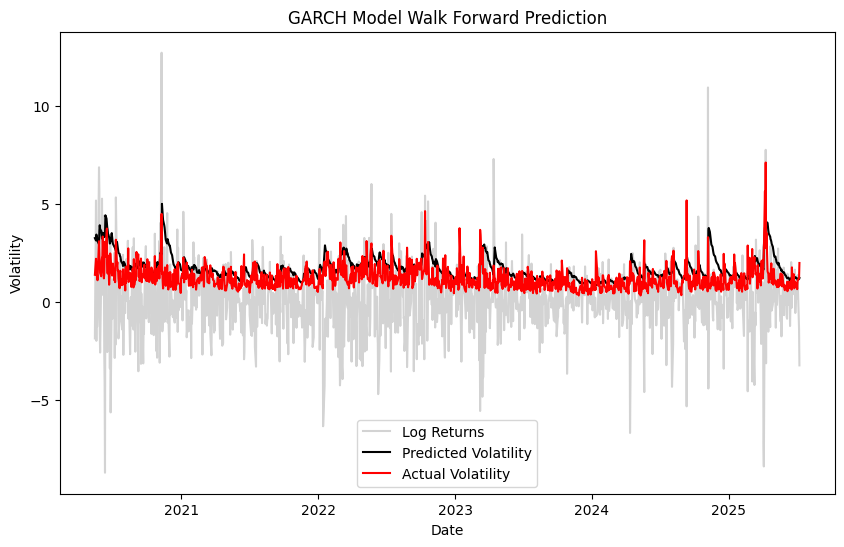

In [72]:
JPM_garch = GARCHWalkForward(finance_data['JPM'])
w_fwd_pred, params_dict, resids = JPM_garch.fit_garch()
JPM_garch.plot_results(w_fwd_pred)      

In [73]:
JPM_garch.evaluate_model(w_fwd_pred)

MAE: 0.6470, MSE: 0.6896, RMSE: 0.8304, QLIKE: 1.6130


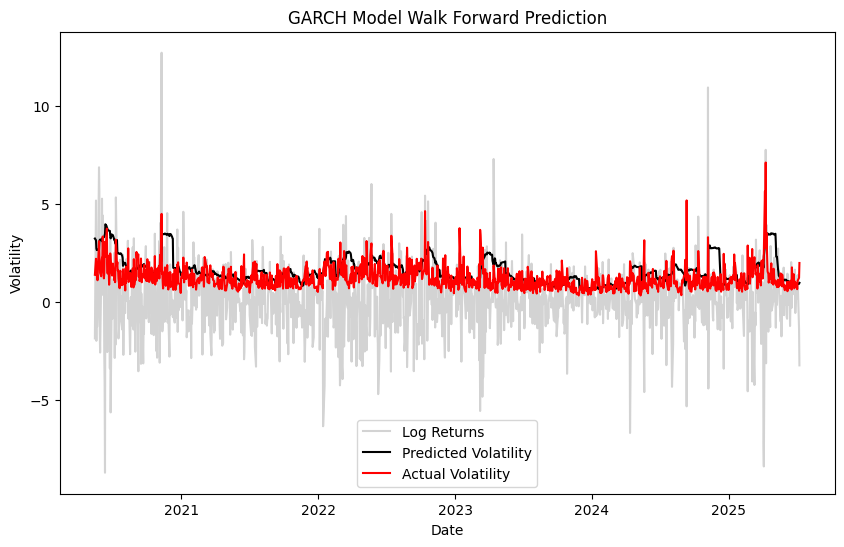

MAE: 0.6045, MSE: 0.6754, RMSE: 0.8218, QLIKE: 1.6324


In [74]:
JPM_hv  = HVmodel(finance_data['JPM'])
JPM_hv_pred = JPM_hv.HVpred()
JPM_hv.plot_results(JPM_hv_pred)
JPM_hv.evaluate_model(JPM_hv_pred)

In [77]:
GS_garch = GARCHWalkForward(finance_data['GS'])
w_fwd_pred, params_dict, resids = GS_garch.fit_garch()
# GS_garch.plot_results(w_fwd_pred)
GS_garch.evaluate_model(w_fwd_pred)

MAE: 0.6656, MSE: 0.6871, RMSE: 0.8289, QLIKE: 1.8326


In [78]:
GS_hv = HVmodel(finance_data['GS'])
hv = GS_hv.HVpred()
# GS_hv.plot_results(hv)
GS_hv.evaluate_model(hv)

MAE: 0.6474, MSE: 0.7446, RMSE: 0.8629, QLIKE: 1.8546


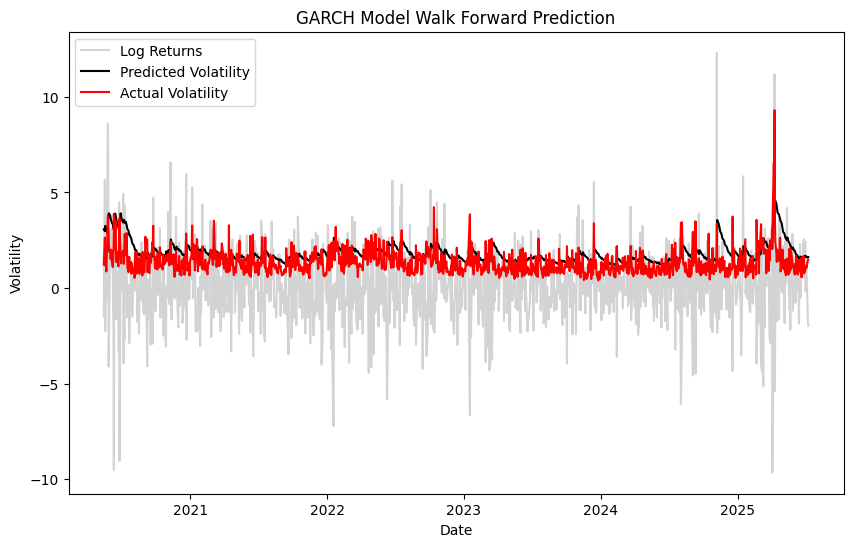

In [79]:
GS_garch.plot_results(w_fwd_pred)

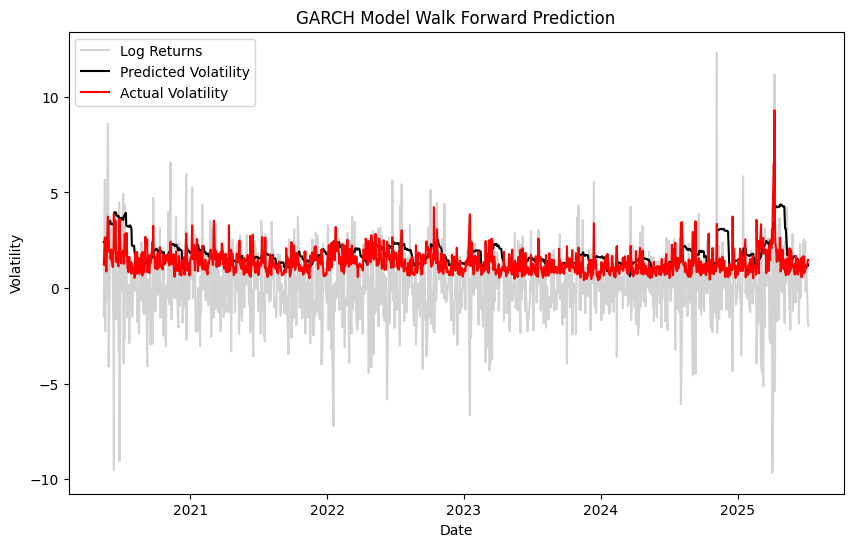

In [80]:
GS_hv.plot_results(hv)

In [81]:
COIN_garch = GARCHWalkForward(crypto_data['COIN'])
w_fwd_pred, params_dict, resids = COIN_garch.fit_garch()
# COIN_garch.plot_results(w_fwd_pred)      
COIN_garch.evaluate_model(w_fwd_pred)

MAE: 2.2617, MSE: 6.7959, RMSE: 2.6069, QLIKE: 3.9599


In [82]:
COIN_hv = HVmodel(crypto_data['COIN'])
hv = COIN_hv.HVpred()
# COIN_hv.plot_results(hv)
COIN_hv.evaluate_model(hv)

MAE: 2.2368, MSE: 7.2816, RMSE: 2.6984, QLIKE: 3.9969
